> RNN(2)-- AbAcAd예제, GPU실험 // LSTM-- abcabC, abcdabcD, LSTM의 계산과정, LSTM은 왜 강한가?

# 강의영상 

<https://youtube.com/playlist?list=PLQqh36zP38-zckrqil6HUKenNLBeiwn1T>

# import

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define some funtions

In [70]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()

# Exam4: AbAcAd (2)

## data

`-` 기존의 정리방식

In [71]:
txt = list('AbAcAd')*100
txt[:10]

['A', 'b', 'A', 'c', 'A', 'd', 'A', 'b', 'A', 'c']

In [72]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [73]:
txt_x[:5],txt_y[:5]

(['A', 'b', 'A', 'c', 'A'], ['b', 'A', 'c', 'A', 'd'])

In [74]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'A':0,'b':1,'c':2,'d':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'A':0,'b':1,'c':2,'d':3}))).float()

In [75]:
x,y

(tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.]]),
 tensor([[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.]]))

## 순환신경망 구현1 (손으로 직접구현) -- 리뷰

`(1)` 숙성담당 네트워크

In [53]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2) 
        self.h2h = torch.nn.Linear(2,2) 
        self.tanh = torch.nn.Tanh()
    def forward(self,x,hidden):
        hidden = self.tanh(self.i2h(x)+self.h2h(hidden))
        return hidden

In [54]:
torch.manual_seed(43052)
rnncell = rNNCell() # 숙성담당 네트워크 

`(2)` 조리담당 네트워크

In [55]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) 

`(3)` 손실함수, 옵티마이저 설계 

In [56]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습 (6분정도 걸림)

In [57]:
T = len(x) 
for epoc in range(5000): 
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht) 
        ot = cook(ht) 
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

In [58]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]]) 

In [59]:
yhat = soft(cook(hidden))
yhat

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4711e-03, 6.1182e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

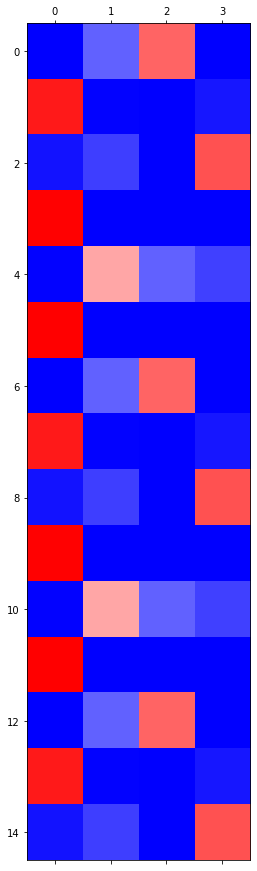

In [60]:
plt.matshow(yhat.data[-15:],cmap='bwr')

## 순환신경망 구현2 (with RNNCell, hidden node 2)

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

### 구현1과 같은 초기값 (확인용) 

`(1)` 숙성네트워크

In [78]:
torch.manual_seed(43052)
_rnncell = rNNCell() # 숙성담당 네트워크 

In [77]:
rnncell = torch.nn.RNNCell(4,2)

`rNNCell()` 는 사실 `torch.nn.RNNCell()`와 같은 동작을 하도록 설계를 하였음. 같은동작을 하는지 확인하기 위해서 동일한 초기상태에서 `rNNCell()`에 의하여 학습된 결과와 `torch.nn.RNNCell()`에 의하여 학습된 결과를 비교해보자.

In [89]:
rnncell.weight_ih.data = _rnncell.i2h.weight.data
rnncell.bias_ih.data = _rnncell.i2h.bias.data
rnncell.weight_hh.data = _rnncell.h2h.weight.data
rnncell.bias_hh.data = _rnncell.h2h.bias.data

`(2)` 조리네트워크

In [90]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 숙성된 2차원의 단어를 다시 4차원으로 바꿔줘야지 나중에 softmax취할 수 있음

`(3)` 손실함수와 옵티마이저 

In [91]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습

In [92]:
T = len(x) 
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

In [98]:
hidden = torch.zeros(T,2) 

In [99]:
# t=0 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
# t=1~T 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [100]:
yhat = soft(cook(hidden))
yhat

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4711e-03, 6.1182e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

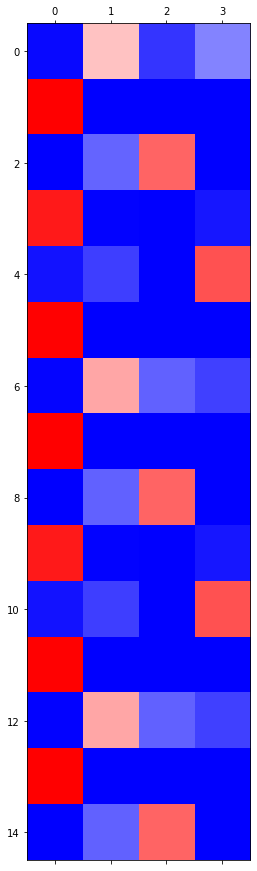

In [101]:
plt.matshow(yhat[:15].data,cmap='bwr')

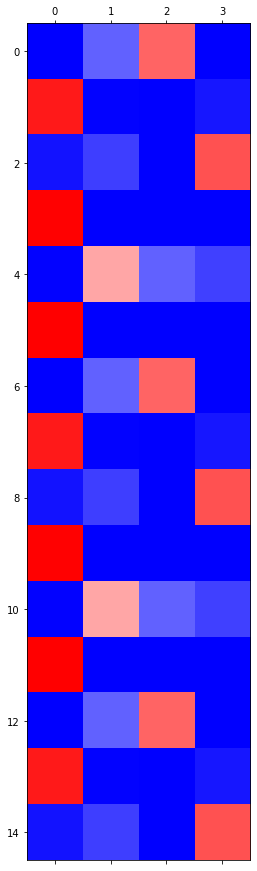

In [102]:
plt.matshow(yhat[-15:].data,cmap='bwr')

### 새로운 초기값

`(1)` 숙성네트워크

In [108]:
torch.manual_seed(43052)
torch.nn.RNNCell(4,2)

RNNCell(4, 2)

`(2)` 조리네트워크

In [109]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 숙성된 2차원의 단어를 다시 4차원으로 바꿔줘야지 나중에 softmax취할 수 있음

`(3)` 손실함수와 옵티마이저 

In [110]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습

In [111]:
T = len(x) 
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

## 순환신경망 구현3 (with RNN, hidden node 2) -- 성공 

(예비학습)

`-` 네트워크학습이후 yhat을 구하려면 번거로웠음 

```Python
hidden = torch.zeros(T,2) 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])
yhat = soft(cook(hidden))
```

`-` 이렇게 하면 쉽게(?) 구할 수 있음 

In [17]:
rnn = torch.nn.RNN(4,2)

In [18]:
rnn.weight_hh_l0.data = rnncell.weight_hh.data 
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data

`-` rnn(x,_water)의 결과는 (1) 599년치 간장 (2) 599번째 간장 이다 

In [19]:
rnn(x,_water), hidden

((tensor([[-0.9912, -0.9117],
          [ 0.0698, -1.0000],
          [-0.9927, -0.9682],
          ...,
          [-0.9935, -0.9315],
          [ 0.5777, -1.0000],
          [-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>),
  tensor([[-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>)),
 tensor([[-0.9912, -0.9117],
         [ 0.0698, -1.0000],
         [-0.9927, -0.9682],
         ...,
         [-0.9935, -0.9315],
         [ 0.5777, -1.0000],
         [-0.9960, -0.0109]], grad_fn=<IndexPutBackward0>))

In [20]:
soft(cook(rnn(x,_water)[0]))

tensor([[1.9725e-02, 1.5469e-03, 8.2766e-01, 1.5106e-01],
        [9.1875e-01, 1.6513e-04, 6.7702e-02, 1.3384e-02],
        [2.0031e-02, 1.0660e-03, 8.5248e-01, 1.2642e-01],
        ...,
        [1.9640e-02, 1.3568e-03, 8.3705e-01, 1.4196e-01],
        [9.9564e-01, 1.3114e-05, 3.5069e-03, 8.4108e-04],
        [3.5473e-03, 1.5670e-01, 1.4102e-01, 6.9873e-01]],
       grad_fn=<SoftmaxBackward0>)

***(예비학습결론) torch.nn.RNN(4,2)는 torch.nn.RNNCell(4,2)의 batch 버전이다. (for문이 포함된 버전이다)***

---

torch.nn.RNN(4,2)를 이용하여 구현하자. 

`(1)` 숙성네트워크

선언

In [21]:
rnn = torch.nn.RNN(4,2)

가중치초기화

In [22]:
torch.manual_seed(43052)
_rnncell = torch.nn.RNNCell(4,2)

In [23]:
rnn.weight_hh_l0.data = _rnncell.weight_hh.data 
rnn.weight_ih_l0.data = _rnncell.weight_ih.data
rnn.bias_hh_l0.data = _rnncell.bias_hh.data
rnn.bias_ih_l0.data = _rnncell.bias_ih.data

`(2)` 조리네트워크

In [24]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) 

`(3)` 손실함수와 옵티마이저

In [25]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [26]:
_water = torch.zeros(1,2) 
for epoc in range(5000):
    ## 1 
    hidden,hT = rnn(x,_water)
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [27]:
yhat = soft(output)

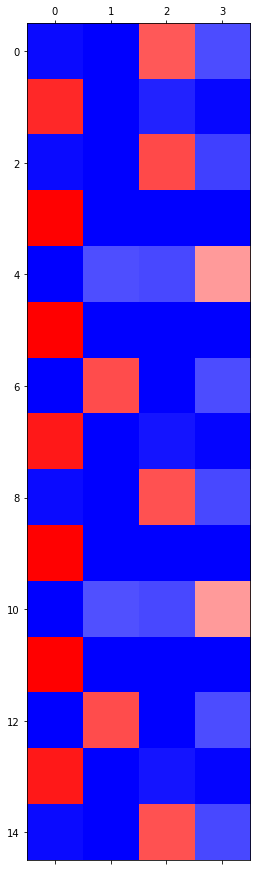

In [28]:
plt.matshow(yhat.data[:15],cmap='bwr')

- 처음은 좀 틀렸음 ㅎㅎ

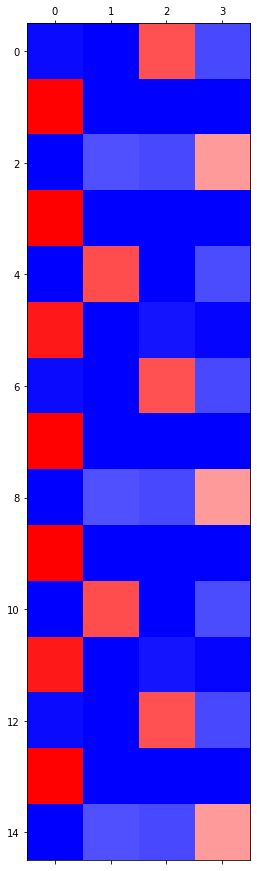

In [29]:
plt.matshow(yhat.data[-15:],cmap='bwr')

- 뒤에는 잘맞음 

**실전팁: `_water` 대신에 `hT`를 대입 (사실 큰 차이는 없음)**

In [30]:
rnn(x[:6],_water),rnn(x[:6],hT)

((tensor([[-0.9912, -0.9117],
          [ 0.0698, -1.0000],
          [-0.9927, -0.9682],
          [ 0.5761, -1.0000],
          [-0.9960, -0.0173],
          [ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>),
  tensor([[ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>)),
 (tensor([[-0.9713, -1.0000],
          [ 0.0535, -1.0000],
          [-0.9925, -0.9720],
          [ 0.5759, -1.0000],
          [-0.9960, -0.0180],
          [ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>),
  tensor([[ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>)))

`(6)` 시각화2: hidden, yhat

In [31]:
combinded = torch.concat([hidden,yhat],axis=1)

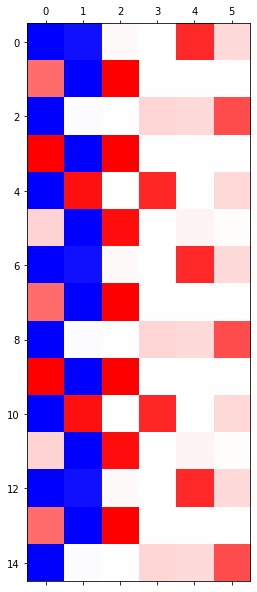

In [32]:
plt.matshow(combinded[-15:].data,cmap='bwr')

- 히든노드의 해석이 어려움. 

## 순환신경망 구현4 (with RNN, hidden node 3) -- 성공 

`(1)` 숙성네트워크~ `(2)` 조리네트워크

In [33]:
torch.manual_seed(2) #1 
rnn = torch.nn.RNN(4,3) 
cook = torch.nn.Linear(3,4) 

`(3)` 손실함수와 옵티마이저

In [34]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [35]:
_water = torch.zeros(1,3) 
for epoc in range(5000):
    ## 1
    hidden,hT = rnn(x,_water) 
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [36]:
yhat = soft(output)

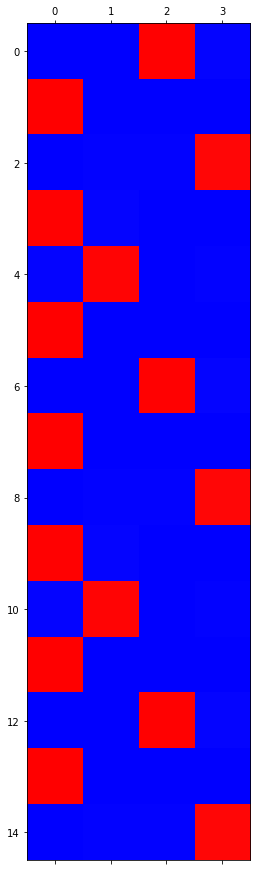

In [37]:
plt.matshow(yhat[-15:].data,cmap='bwr')

`(6)` 시각화2: hidden, yhat

In [38]:
combinded = torch.concat([hidden,yhat],axis=1)

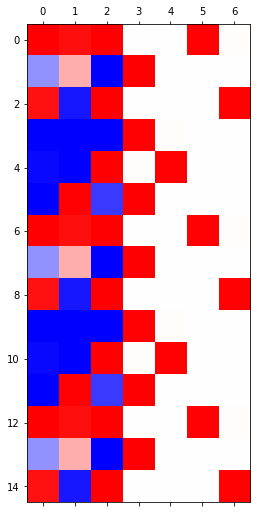

In [39]:
plt.matshow(combinded[-15:].data,cmap='bwr')

- 세번째 히든노드 = 대소문자를 구분
- 1,2 히든노드 = bcd를 구분 

# GPU 실험

## 20000 len + 20 hidden nodes

***cpu***

In [3]:
x = torch.randn([20000,4]) 
y = torch.randn([20000,4]) 

In [5]:
rnn = torch.nn.RNN(4,20) 
linr = torch.nn.Linear(20,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [6]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

93.01761960983276

***gpu***

In [9]:
x = torch.randn([20000,4]).to("cuda:0")
y = torch.randn([20000,4]).to("cuda:0")

In [10]:
rnn = torch.nn.RNN(4,20).to("cuda:0")
linr = torch.nn.Linear(20,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [11]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

3.2665085792541504

- 왜 빠른지? 

## 20000 len + 20 hidden nodes + 역전파주석처리 

***cpu***

In [31]:
x = torch.randn([20000,4]) 
y = torch.randn([20000,4]) 

In [32]:
rnn = torch.nn.RNN(4,20) 
linr = torch.nn.Linear(20,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [33]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

18.851768255233765

***gpu***

In [34]:
x = torch.randn([20000,4]).to("cuda:0")
y = torch.randn([20000,4]).to("cuda:0")

In [35]:
rnn = torch.nn.RNN(4,20).to("cuda:0")
linr = torch.nn.Linear(20,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [36]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

1.2901742458343506

## 2000 len + 20 hidden nodes 

***cpu***

In [37]:
x = torch.randn([2000,4]) 
y = torch.randn([2000,4]) 

In [38]:
rnn = torch.nn.RNN(4,20) 
linr = torch.nn.Linear(20,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [39]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

6.533619165420532

***gpu***

In [40]:
x = torch.randn([2000,4]).to("cuda:0")
y = torch.randn([2000,4]).to("cuda:0")

In [41]:
rnn = torch.nn.RNN(4,20).to("cuda:0")
linr = torch.nn.Linear(20,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [42]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

0.7532594203948975

## 2000 len + 20 hidden nodes + 역전파주석처리

***cpu***

In [67]:
x = torch.randn([2000,4]) 
y = torch.randn([2000,4]) 

In [68]:
rnn = torch.nn.RNN(4,20) 
linr = torch.nn.Linear(20,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [69]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

1.2477965354919434

***gpu***

In [70]:
x = torch.randn([2000,4]).to("cuda:0")
y = torch.randn([2000,4]).to("cuda:0")

In [71]:
rnn = torch.nn.RNN(4,20).to("cuda:0")
linr = torch.nn.Linear(20,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [72]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

0.14130854606628418

## 2000 len + 5000 hidden nodes 

***cpu***

In [80]:
x = torch.randn([2000,4]) 
y = torch.randn([2000,4]) 

In [81]:
rnn = torch.nn.RNN(4,1000) 
linr = torch.nn.Linear(1000,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [83]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,1000)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

58.99820685386658

***gpu***

In [84]:
x = torch.randn([2000,4]).to("cuda:0")
y = torch.randn([2000,4]).to("cuda:0")

In [85]:
rnn = torch.nn.RNN(4,1000).to("cuda:0")
linr = torch.nn.Linear(1000,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [86]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,1000).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

4.7596595287323

## 2000 len + 5000 hidden nodes + 역전파주석처리

***cpu***

In [91]:
x = torch.randn([2000,4]) 
y = torch.randn([2000,4]) 

In [92]:
rnn = torch.nn.RNN(4,1000) 
linr = torch.nn.Linear(1000,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [93]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,1000)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

13.163657188415527

***gpu***

In [94]:
x = torch.randn([2000,4]).to("cuda:0")
y = torch.randn([2000,4]).to("cuda:0")

In [95]:
rnn = torch.nn.RNN(4,1000).to("cuda:0")
linr = torch.nn.Linear(1000,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [96]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,1000).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

2.2989864349365234

## 실험결과 요약 

|len |# of hidden nodes | backward |cpu | gpu| ratio| 
|:-:|:-:|:-:|:-:|:-:|:-:|
|20000 | 20| O | 93.02 | 3.26 | 28.53 |
|20000 | 20| X | 18.85 | 1.29 | 14.61 | 
|2000 | 20| O | 6.53 | 0.75 | 8.70 | 
|2000 | 20| X | 1.25 | 0.14 | 8.93 |
|2000 | 1000| O | 58.99 | 4.75 | 12.41 | 
|2000 | 1000| X | 13.16 | 2.29 | 5.74 |

# Exam5: abcabC

## data 

In [160]:
txt = list('abcabC')*100
txt[:8]

['a', 'b', 'c', 'a', 'b', 'C', 'a', 'b']

In [161]:
txt_x = txt[:-1] 
txt_y = txt[1:]

In [162]:
mapping = {'a':0,'b':1,'c':2,'C':3} 
x= torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y= torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

In [163]:
x = x.to("cuda:0")
y = y.to("cuda:0") 

In [164]:
x.shape

torch.Size([599, 4])

## RNN 

In [110]:
torch.manual_seed(43052) 
rnn = torch.nn.RNN(4,3) 
linr = torch.nn.Linear(3,4) 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+ list(linr.parameters()))

In [111]:
rnn.to("cuda:0") 
linr.to("cuda:0")

Linear(in_features=3, out_features=4, bias=True)

`-` 3000 epochs

In [112]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [116]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

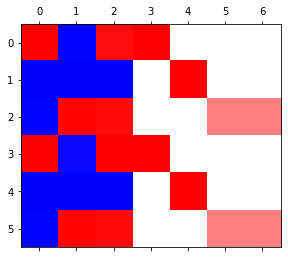

In [118]:
plt.matshow(combinded[-6:],cmap='bwr')

`-` 6000 epochs

In [119]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [120]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

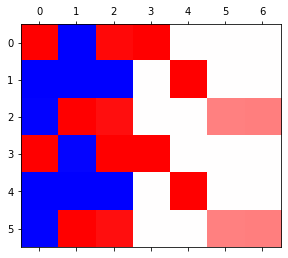

In [121]:
plt.matshow(combinded[-6:],cmap='bwr')

`-` 9000 epochs

In [122]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [123]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

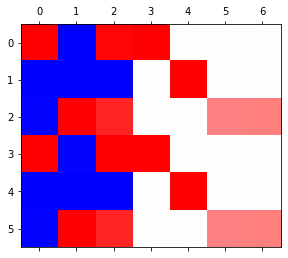

In [124]:
plt.matshow(combinded[-6:],cmap='bwr')

`-` 12000 epochs

In [125]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [126]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

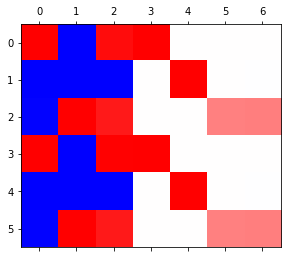

In [127]:
plt.matshow(combinded[-6:],cmap='bwr')

`-` 15000 epochs

In [128]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [129]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

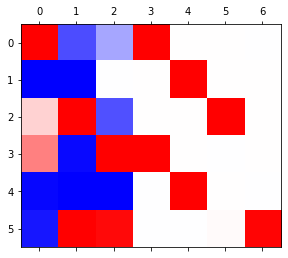

In [132]:
plt.matshow(combinded[-6:],cmap='bwr')

## LSTM 

`-` LSTM 

In [133]:
torch.manual_seed(43052) 
lstm = torch.nn.LSTM(4,3) 
linr = torch.nn.Linear(3,4) 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters())+ list(linr.parameters()))

In [134]:
lstm.to("cuda:0") 
linr.to("cuda:0")

Linear(in_features=3, out_features=4, bias=True)

`-` 3000 epochs

In [136]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, (hT,cT) = lstm(x,(_water,_water))
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [139]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

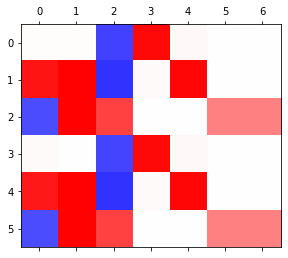

In [141]:
plt.matshow(combinded[-6:],cmap='bwr',vmin=-1,vmax=1)

`-` 6000 epochs

In [142]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, (hT,cT) = lstm(x,(_water,_water))
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [143]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

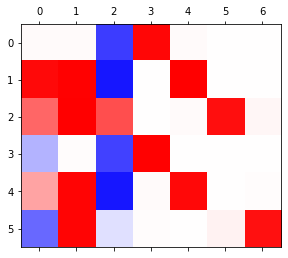

In [144]:
plt.matshow(combinded[-6:],cmap='bwr',vmin=-1,vmax=1)

## RNN vs LSTM 성능비교실험

`-` RNN 

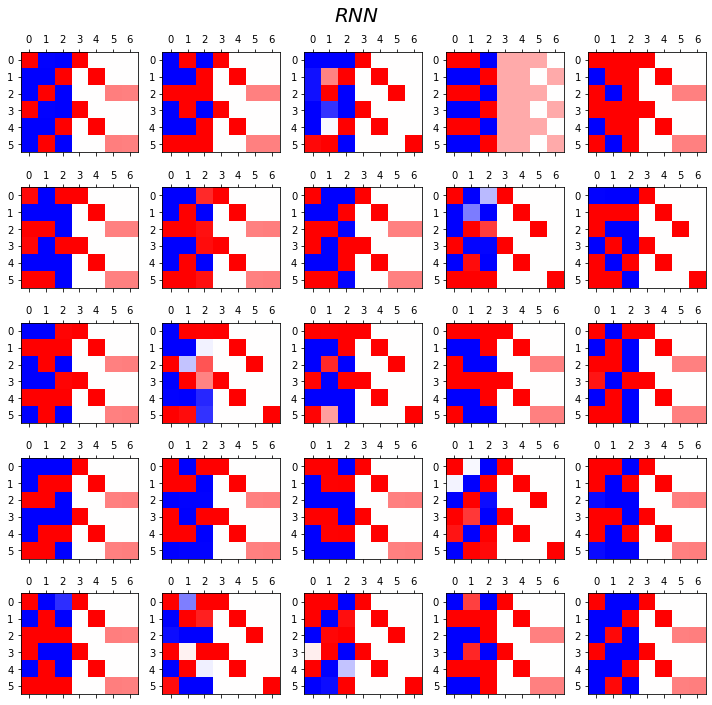

In [167]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,3).to("cuda:0")
        linr = torch.nn.Linear(3,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()),lr=0.1)
        _water = torch.zeros(1,3).to("cuda:0")
        for epoc in range(3000):
            ## 1
            hidden, hT = rnn(x,_water)
            output = linr(hidden)
            ## 2
            loss = loss_fn(output,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        yhat=soft(output)    
        combind = torch.concat([hidden,yhat],axis=1)
        ax[i][j].matshow(combind.to("cpu").data[-6:],cmap='bwr',vmin=-1,vmax=1)
fig.suptitle(r"$RNN$",size=20)
fig.tight_layout()

`-` LSTM

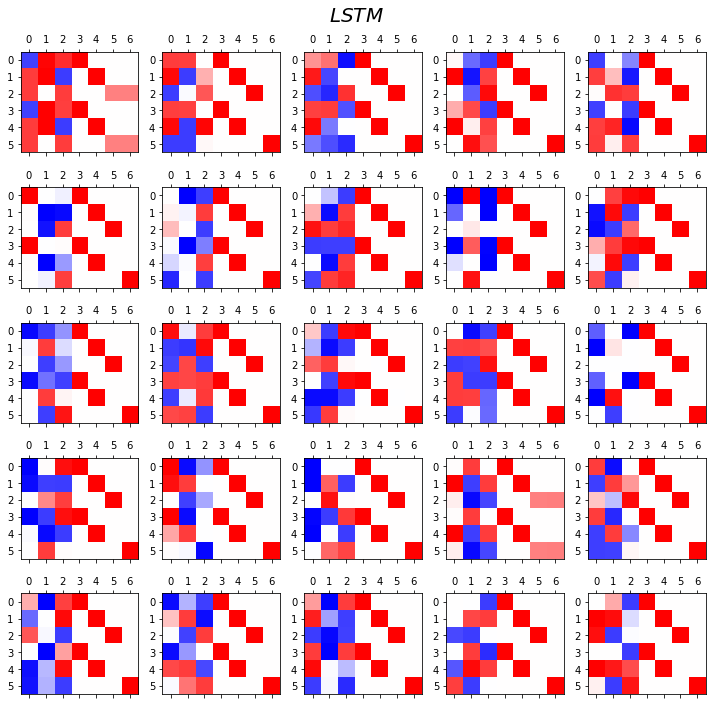

In [168]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        lstm = torch.nn.LSTM(4,3).to("cuda:0")
        linr = torch.nn.Linear(3,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(lstm.parameters())+list(linr.parameters()),lr=0.1)
        _water = torch.zeros(1,3).to("cuda:0")
        for epoc in range(3000):
            ## 1
            hidden, (hT,cT) = lstm(x,(_water,_water))
            output = linr(hidden)
            ## 2
            loss = loss_fn(output,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        yhat=soft(output)    
        combind = torch.concat([hidden,yhat],axis=1)
        ax[i][j].matshow(combind.to("cpu").data[-6:],cmap='bwr',vmin=-1,vmax=1)
fig.suptitle(r"$LSTM$",size=20)
fig.tight_layout()

# Exam6: abcdabcD

## data

In [169]:
txt = list('abcdabcD')*100
txt[:8]

['a', 'b', 'c', 'd', 'a', 'b', 'c', 'D']

In [170]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [171]:
mapping = {'a':0, 'b':1, 'c':2, 'd':3, 'D':4}
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

In [172]:
x=x.to("cuda:0")
y=y.to("cuda:0")

## RNN vs LSTM 성능비교실험

`-` RNN 

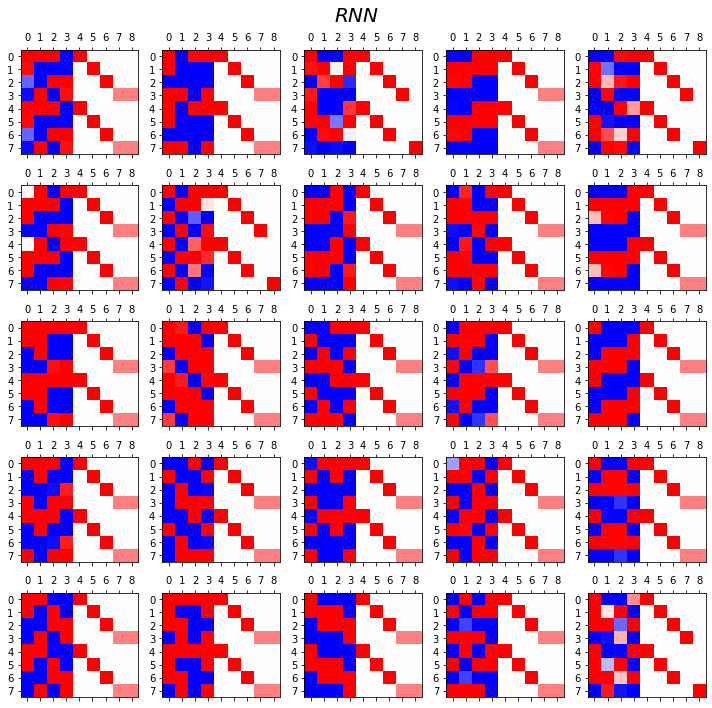

In [173]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(5,4).to("cuda:0")
        linr = torch.nn.Linear(4,5).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()),lr=0.1)
        _water = torch.zeros(1,4).to("cuda:0")
        for epoc in range(3000):
            ## 1
            hidden, hT = rnn(x,_water)
            output = linr(hidden)
            ## 2
            loss = loss_fn(output,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        yhat=soft(output)    
        combind = torch.concat([hidden,yhat],axis=1)
        ax[i][j].matshow(combind.to("cpu").data[-8:],cmap='bwr',vmin=-1,vmax=1)
fig.suptitle(r"$RNN$",size=20)
fig.tight_layout()

`-` LSTM

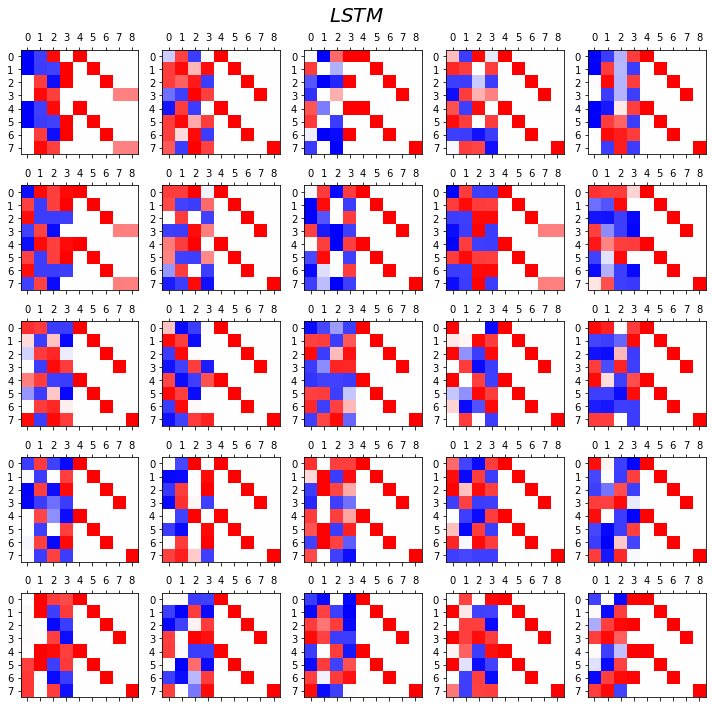

In [174]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        lstm = torch.nn.LSTM(5,4).to("cuda:0")
        linr = torch.nn.Linear(4,5).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(lstm.parameters())+list(linr.parameters()),lr=0.1)
        _water = torch.zeros(1,4).to("cuda:0")
        for epoc in range(3000):
            ## 1
            hidden, (hT,cT) = lstm(x,(_water,_water))
            output = linr(hidden)
            ## 2
            loss = loss_fn(output,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        yhat=soft(output)    
        combind = torch.concat([hidden,yhat],axis=1)
        ax[i][j].matshow(combind.to("cpu").data[-8:],cmap='bwr',vmin=-1,vmax=1)
fig.suptitle(r"$LSTM$",size=20)
fig.tight_layout()

`-` 관찰1: LSTM이 확실히 장기기억에 강하다. 

`-` 관찰2: LSTM은 hidden에 0이 잘 나온다. 

- 사실 확실히 구분되는 특징을 판별할때는 -1,1 로 히든레이어 값들이 설정되면 명확하다. 
- 히든레이어에 -1~1사이의 값이 나온다면 애매한 판단이 내려지게 된다. 
- 그런데 이 애매한 판단이 어떻게 보면 문맥의 뉘앙스를 이해하는데 더 잘 맞다.
- 그런데 RNN은 -1,1로 셋팅된 상황에서 -1~1로의 변화가 더디다는 것이 문제임. 

# LSTM의 계산과정

## data: abaB

In [3]:
txt = list('abaB')*100
txt[:5]

['a', 'b', 'a', 'B', 'a']

In [4]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [5]:
mapping = {'a':0, 'b':1, 'B':2}
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

## 1 epoch ver1 (with torch.nn.LSTMCell)

In [6]:
torch.manual_seed(43052) 
lstm_cell = torch.nn.LSTMCell(3,2) 
linr = torch.nn.Linear(2,3)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm_cell.parameters())+list(linr.parameters()),lr=0.1)

In [9]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0 
    ## 1~2
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht,ct = lstm_cell(xt,(ht,ct))
        ot = linr(ht) 
        loss = loss + loss_fn(ot,yt)
    loss = loss / T
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [10]:
ht,ct 

(tensor([[-0.0406,  0.2505]], grad_fn=<MulBackward0>),
 tensor([[-0.0975,  0.7134]], grad_fn=<AddBackward0>))

## 1 epoch ver2 (완전 손으로 구현) 

### ***t=0 $\to$ t=1***

`-` lstm_cell 을 이용한 계산 (결과비교용)

In [12]:
torch.manual_seed(43052) 
lstm_cell = torch.nn.LSTMCell(3,2) 
linr = torch.nn.Linear(2,3)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm_cell.parameters())+list(linr.parameters()),lr=0.1)

In [13]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0 
    ## 1~2
    for t in range(1):
        xt,yt = x[[t]], y[[t]]
        ht,ct = lstm_cell(xt,(ht,ct))
    #     ot = linr(ht) 
    #     loss = loss + loss_fn(ot,yt)
    # loss = loss / T
    # ## 3 
    # loss.backward()
    # ## 4 
    # optimizr.step()
    # optimizr.zero_grad()

In [14]:
ht,ct 

(tensor([[-0.0541,  0.0892]], grad_fn=<MulBackward0>),
 tensor([[-0.1347,  0.2339]], grad_fn=<AddBackward0>))

- 이런결과를 어떻게 만드는걸까? 
- <https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>

`-` 직접계산 

In [25]:
ht = torch.zeros(1,2)
ct = torch.zeros(1,2)

In [26]:
_ifgo = xt @ lstm_cell.weight_ih.T + ht @ lstm_cell.weight_hh.T + lstm_cell.bias_ih + lstm_cell.bias_hh

In [27]:
input_gate = sig(_ifgo[:,0:2])
forget_gate = sig(_ifgo[:,2:4])
gt = tanh(_ifgo[:,4:6])
output_gate = sig(_ifgo[:,6:8])

In [28]:
ct = forget_gate * ct + input_gate * gt
ht = output_gate * tanh(ct)

In [29]:
ht,ct

(tensor([[-0.0541,  0.0892]], grad_fn=<MulBackward0>),
 tensor([[-0.1347,  0.2339]], grad_fn=<AddBackward0>))

### ***t=0 $\to$ t=T***

In [30]:
torch.manual_seed(43052) 
lstm_cell = torch.nn.LSTMCell(3,2) 
linr = torch.nn.Linear(2,3)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm_cell.parameters())+list(linr.parameters()),lr=0.1)

In [31]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0 
    ## 1~2
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        
        ## lstm_cell step1: calculate _ifgo 
        _ifgo = xt @ lstm_cell.weight_ih.T + ht @ lstm_cell.weight_hh.T + lstm_cell.bias_ih + lstm_cell.bias_hh
        ## lstm_cell step2: decompose _ifgo 
        input_gate = sig(_ifgo[:,0:2])
        forget_gate = sig(_ifgo[:,2:4])
        gt = tanh(_ifgo[:,4:6])
        output_gate = sig(_ifgo[:,6:8])
        ## lstm_cell step3: calculate ht,ct 
        ct = forget_gate * ct + input_gate * gt
        ht = output_gate * tanh(ct)
        
    #     ot = linr(ht) 
    #     loss = loss + loss_fn(ot,yt)
    # loss = loss / T
    # ## 3 
    # loss.backward()
    # ## 4 
    # optimizr.step()
    # optimizr.zero_grad()

In [32]:
ht,ct

(tensor([[-0.0406,  0.2505]], grad_fn=<MulBackward0>),
 tensor([[-0.0975,  0.7134]], grad_fn=<AddBackward0>))

## 1 epoch ver3 (with torch.nn.LSTM)

In [42]:
torch.manual_seed(43052) 
lstm_cell = torch.nn.LSTMCell(3,2)
linr = torch.nn.Linear(2,3) 

In [43]:
lstm = torch.nn.LSTM(3,2) 

In [44]:
lstm.weight_hh_l0.data = lstm_cell.weight_hh.data 
lstm.bias_hh_l0.data = lstm_cell.bias_hh.data 
lstm.weight_ih_l0.data = lstm_cell.weight_ih.data 
lstm.bias_ih_l0.data = lstm_cell.bias_ih.data 

In [45]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters()) + list(linr.parameters()), lr=0.1) 

In [46]:
_water = torch.zeros(1,2) 
for epoc in range(1): 
    ## step1 
    hidden, (ht,ct) = lstm(x,(_water,_water))
    output = linr(hidden)
    # ## step2
    # loss = loss_fn(output,y) 
    # ## step3
    # loss.backward()
    # ## step4 
    # optimizr.step()
    # optimizr.zero_grad() 

In [47]:
ht,ct

(tensor([[-0.0406,  0.2505]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.0975,  0.7134]], grad_fn=<SqueezeBackward1>))

# LSTM은 왜 강한가? 

## data: abaB

In [48]:
txt = list('abaB')*100
txt[:5]

['a', 'b', 'a', 'B', 'a']

In [49]:
n_words = 3

In [50]:
mapping = {'a':0, 'b':1, 'B':2}

In [51]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [52]:
txt_x[:10],txt_y[:10]

(['a', 'b', 'a', 'B', 'a', 'b', 'a', 'B', 'a', 'b'],
 ['b', 'a', 'B', 'a', 'b', 'a', 'B', 'a', 'b', 'a'])

In [53]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

In [54]:
x,y

(tensor([[1., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.]]),
 tensor([[0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.],
         ...,
         [0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.]]))

## 1000 epoch 

In [108]:
torch.manual_seed(43052) 
lstm = torch.nn.LSTM(3,2) 
linr = torch.nn.Linear(2,3) 

In [109]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm.parameters())+ list(linr.parameters()),lr=0.1)

In [110]:
_water = torch.zeros(1,2) 
for epoc in range(1000): 
    ## step1 
    hidden, (ht,ct) = lstm(x,(_water,_water))
    output = linr(hidden)
    ## step2
    loss = loss_fn(output,y) 
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad() 

## 시각화 

In [117]:
T = len(x)
input_gate = torch.zeros(T,2)
forget_gate = torch.zeros(T,2)
output_gate = torch.zeros(T,2)
g = torch.zeros(T,2)
cell = torch.zeros(T,2)
h = torch.zeros(T,2) 

In [118]:
for t in range(T): 
    ## 1: calculate _ifgo 
    _ifgo = x[[t]] @ lstm.weight_ih_l0.T + h[[t]] @ lstm.weight_hh_l0.T + lstm.bias_ih_l0 + lstm.bias_hh_l0 
    ## 2: decompose _ifgo 
    input_gate[[t]] = sig(_ifgo[:,0:2])
    forget_gate[[t]] = sig(_ifgo[:,2:4])
    g[[t]] = tanh(_ifgo[:,4:6])
    output_gate[[t]] = sig(_ifgo[:,6:8])
    ## 3: calculate ht,ct 
    cell[[t]] = forget_gate[[t]] * cell[[t]] + input_gate[[t]] * g[[t]]
    h[[t]] = output_gate[[t]] * tanh(cell[[t]])

In [120]:
combinded1 = torch.concat([input_gate,forget_gate,output_gate],axis=1)
combinded2 = torch.concat([g,cell,h,soft(output)],axis=1)

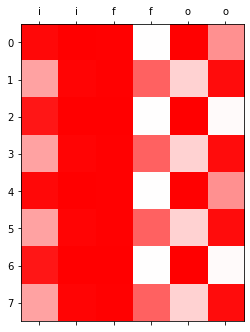

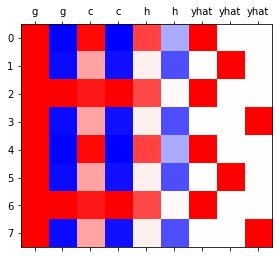

In [143]:
plt.matshow(combinded1[-8:].data,cmap='bwr',vmin=-1,vmax=1);
plt.xticks(range(combinded1.shape[-1]),labels=['i']*2 + ['f']*2 + ['o']*2);
plt.matshow(combinded2[-8:].data,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(combinded2.shape[-1]),labels=['g']*2 + ['c']*2 + ['h']*2 + ['yhat']*3);

- 상단그림은 게이트의 값들만 시각화, 하단그림은 게이트 이외의 값들을 시각화 

## 시각화의 해석I 

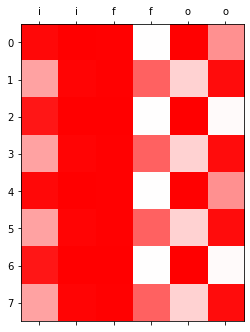

In [145]:
plt.matshow(combinded1[-8:].data,cmap='bwr',vmin=-1,vmax=1);
plt.xticks(range(combinded1.shape[-1]),labels=['i']*2 + ['f']*2 + ['o']*2);

`-` input_gate, forget_gate, output_gate는 모두 0~1 사이의 값을 가진다. 

`-` 이 값들은 각각 모두 ${\boldsymbol g}_t, {\boldsymbol c}_{t-1}, \tanh({\boldsymbol c}_t)$에 곱해진다. 따라서 input_gate, forget_gate, output_gate 는 gate의 역할로 비유가능하다. (1이면 통과, 0이면 차단)

- input_gate: ${\boldsymbol g}_t$의 값을 얼만큼 통과시킬지 0~1사이의 숫자로 결정 
- forget_gate: ${\boldsymbol c}_{t-1}$의 값을 얼만큼 통과시킬지 0~1사이의 숫자로 결정 
- output_gate: $\tanh({\boldsymbol c}_t)$의 값을 얼만큼 통과시킬지 0~1사이의 숫자로 결정 

## 시각화의 해석II

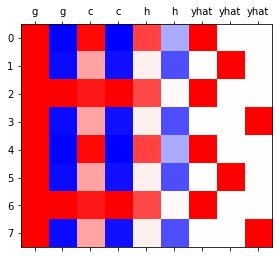

In [142]:
plt.matshow(combinded2[-8:].data,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(combinded2.shape[-1]),labels=['g']*2 + ['c']*2 + ['h']*2 + ['yhat']*3);

`-` 결국 ${\boldsymbol g}_t\to {\boldsymbol c}_t \to {\boldsymbol h}_t \to \hat{\boldsymbol y}$ 의 느낌이다. (${\boldsymbol h}_t$를 계산하기 위해서는 ${\boldsymbol c}_t$가 필요했고 ${\boldsymbol c}_t$를 계산하기 위해서는 ${\boldsymbol c}_{t-1}$과 ${\boldsymbol g}_t$가 필요했음) 

- ${\boldsymbol h}_t= \tanh({\boldsymbol c}_t) \odot {\boldsymbol o}_t$
- ${\boldsymbol c}_t ={\boldsymbol c}_{t-1} \odot {\boldsymbol f}_t + {\boldsymbol g}_{t} \odot {\boldsymbol i}_t$

`-` ${\boldsymbol g}_t,{\boldsymbol c}_t,{\boldsymbol h}_t$ 모두 ${\boldsymbol x}_t$의 정보를 숙성시켜 가지고 있는 느낌이 든다. 

`-` ${\boldsymbol g}_t$ 특징: 보통 -1,1 중 하나의 값을 가지도록 학습되어 있다. (마치 RNN의 hidden node처럼!) 

- $\boldsymbol{g}_t = \tanh({\boldsymbol x}_t {\bf W}_{ig} + {\boldsymbol h}_{t-1} {\bf W}_{hg}+ {\boldsymbol b}_{ig}+{\boldsymbol b}_{hg})$

`-` ${\boldsymbol c}_t$ 특징: ${\boldsymbol g}_t$와 매우 비슷하지만 약간 다른값을 가진다. 그래서 ${\boldsymbol g}_t$와는 달리 -1,1 이외의 값도 종종 등장. 

In [249]:
print("first row: gt={}, ct={}".format(g[-8].data, cell[-8].data))
print("second row: gt={}, ct={}".format(g[-7].data, cell[-7].data))
#g[-7], cell[-7]

first row: gt=tensor([ 0.9999, -0.9999]), ct=tensor([ 0.9647, -0.9984])
second row: gt=tensor([ 0.9970, -0.9554]), ct=tensor([ 0.3592, -0.9373])


`-` ${\boldsymbol h}_t$ 특징: (1) ${\boldsymbol c}_t$의 느낌이 있음 하지만 약간의 변형이 있음. (2) -1~1 사이에의 값을 훨씬 다양하게 가진다. (tanh때문)

In [251]:
print("first row: gt={}, ct={}, ht={}".format(g[-8].data, cell[-8].data,h[-8].data))
print("second row: gt={}, ct={}, ht={}".format(g[-7].data, cell[-7].data,h[-7].data))
#g[-7], cell[-7]

first row: gt=tensor([ 0.9999, -0.9999]), ct=tensor([ 0.9647, -0.9984]), ht=tensor([ 0.7370, -0.3323])
second row: gt=tensor([ 0.9970, -0.9554]), ct=tensor([ 0.3592, -0.9373]), ht=tensor([ 0.0604, -0.6951])


`-` 예전의문 해결

- 실험적으로 살펴보니 LSTM이 RNN보다 장기기억에 유리했음.
- 그 이유: RRN은 ${\boldsymbol h}_t$의 값이 -1 혹은 1로 결정되는 경우가 많았음. 그러나 경우에 따라서는 ${\boldsymbol h}_t$이 -1~1의 값을 가지는 것이 문맥적 뉘앙스를 포착하기에는 유리한데 LSTM이 이러한 방식으로 학습되는 경우가 많았음. 
- 왜 LSTM의 ${\boldsymbol h}_t$은 -1,1 이외의 값을 쉽게 가질 수 있는가? (1) gate들의 역할 (2) 마지막에 취해지는 tanh 때문 

## LSTM의 알고리즘 리뷰 I (수식위주)

**(step1)** calculate ${\tt ifgo}$

${\tt ifgo} = {\boldsymbol x}_t  \big[{\bf W}_{ii} | {\bf W}_{if}| {\bf W}_{ig} |{\bf W}_{io}\big] + {\boldsymbol h}_{t-1}  \big[ {\bf W}_{hi}|{\bf W}_{hf} |{\bf W}_{hg} | {\bf W}_{ho} \big] + bias$

$=\big[{\boldsymbol x}_t{\bf W}_{ii} + {\boldsymbol h}_{t-1}{\bf W}_{hi} ~\big|~ {\boldsymbol x}_t{\bf W}_{if}+ {\boldsymbol h}_{t-1}{\bf W}_{hf}~ \big|~ {\boldsymbol x}_t{\bf W}_{ig} + {\boldsymbol h}_{t-1}{\bf W}_{hg}  ~\big|~ {\boldsymbol x}_t{\bf W}_{io} + {\boldsymbol h}_{t-1}{\bf W}_{ho} \big] + bias$

참고: 위의 수식은 아래코드에 해당하는 부분

```Python
ifgo = xt @ lstm_cell.weight_ih.T +\
       ht @ lstm_cell.weight_hh.T +\
       lstm_cell.bias_ih + lstm_cell.bias_hh
```

**(step2)** decompose ${\tt ifgo}$ and get ${\boldsymbol i}_t$, ${\boldsymbol f}_t$, ${\boldsymbol g}_t$, ${\boldsymbol o}_t$

${\boldsymbol i}_t = \sigma({\boldsymbol x}_t {\bf W}_{ii} + {\boldsymbol h}_{t-1} {\bf W}_{hi} +bias )$ 

${\boldsymbol f}_t = \sigma({\boldsymbol x}_t {\bf W}_{if} + {\boldsymbol h}_{t-1} {\bf W}_{hf} +bias )$ 

${\boldsymbol g}_t = \tanh({\boldsymbol x}_t {\bf W}_{ig} + {\boldsymbol h}_{t-1} {\bf W}_{hg} +bias )$ 

${\boldsymbol o}_t = \sigma({\boldsymbol x}_t {\bf W}_{io} + {\boldsymbol h}_{t-1} {\bf W}_{ho} +bias )$ 

**(step3)** calculate ${\boldsymbol c}_t$ and ${\boldsymbol h}_t$

${\boldsymbol c}_t = {\boldsymbol i}_t \odot {\boldsymbol g}_t+ {\boldsymbol f}_t \odot {\boldsymbol c}_{t-1}$

${\boldsymbol h}_t = \tanh({\boldsymbol o}_t \odot {\boldsymbol c}_t)$

## LSTM의 알고리즘 리뷰 II (느낌위주)

- 이해 및 암기를 돕기위해서 비유적으로 설명한 챕터입니다..

`-` 느낌1: RNN이 콩물에서 간장을 한번에 숙성시키는 방법이라면 LSTM은 콩물에서 간장을 3차로 나누어 숙성하는 느낌이다. 

- 콩물: ${\boldsymbol x}_t$
- 1차숙성: ${\boldsymbol g}_t$
- 2차숙성: ${\boldsymbol c}_t$ 
- 3차숙성: ${\boldsymbol h}_t$ 

`-` 느낌2: ${\boldsymbol g}_t$에 대하여

- 계산방법: ${\boldsymbol x}_t$와 ${\boldsymbol h}_{t-1}$를 ${\bf W}_{ig}, {\bf W}_{hg}$를 이용해 선형결합하고 $\tanh$를 취한 결과
- RNN에서 간장을 만들던 그 수식에서 $h_t$를 $g_t$로 바꾼것 
- 크게 2가지의 의미를 가진다 (1) 과거와 현재의 결합 (2) 활성화함수 $\tanh$를 적용 

`-` 느낌3: ${\boldsymbol c}_t$에 대하여 (1)

- 계산방법: ${\boldsymbol g}_{t}$와 ${\boldsymbol c}_{t-1}$를 요소별로 선택하고 더하는 과정 
- $g_t$는 (1) 과거와 현재의 결합 (2) 활성화함수 tanh를 적용으로 나누어지는데 이중에서 (1) 과거와 현재의 정보를 결합하는 과정만 해당한다. 차이점은 요소별 선택 후 덧셈
- 이러한 결합을 쓰는 이유? 게이트를 이용하여 과거와 현재의 정보를 제어 (일반적인 설명, 솔직히 내가 좋아하는 설명은 아님)

`-` 느낌4: ${\boldsymbol c}_t$에 대하여 (2) // ${\boldsymbol c}_t$는 왜 과거와 현재의 정보를 제어한다고 볼 수 있는가? 

$t=1$ 시점 계산과정관찰

In [266]:
input_gate[1],g[1],forget_gate[1],cell[0]

(tensor([0.9065, 0.9999], grad_fn=<SelectBackward0>),
 tensor([0.9931, 0.9999], grad_fn=<SelectBackward0>),
 tensor([0.9931, 0.0014], grad_fn=<SelectBackward0>),
 tensor([ 0.3592, -0.9373], grad_fn=<SelectBackward0>))

$[0.9,1.0] \odot {\boldsymbol g}_t + [1.0,0.0] \odot {\boldsymbol c}_{t-1}$

- forget_gate는 $c_{t-1}$의 첫번째 원소는 기억하고, 두번째 원소는 잊으라고 말하고 있음 // forget_gate는 과거($c_{t-1}$)의 정보를 얼마나 잊을지 (= 얼마나 기억할지) 를 결정한다고 해석할 수 있다. 
- input_gate는 $g_{t}$의 첫번째 원소와 두번째 원소를 모두 기억하되 두번째 원소를 좀 더 중요하게 기억하라고 말하고 있음 // input_gate는 현재($g_{t}$)의 정보를 얼만큼 강하게 반영할지 결정한다. 
- 이 둘을 조합하면 ${\boldsymbol c}_t$가 현재와 과거의 정보중 어떠한 정보를 더 중시하면서 기억할지 결정한다고 볼 수 있다. 

> 이 설명은 제가 좀 싫어해요, 싫어하는 이유는 (1) "기억의 정도를 조절한다"와 "망각의 정도를 조절한다"는 사실 같은말임. 그래서 forget_gate의 용어가 모호함. (2) 기억과 망각을 조정하는 방식으로 꼭 gate의 개념을 사용해야 하는건 아님

`-` 느낌5: ${\boldsymbol c}_t$에 대하여 (3) 

- 사실상 LSTM 알고리즘의 꽃이라 할 수 있음. 
- LSTM은 long short term memory의 약자임. 기존의 RNN은 장기기억을 활용함에 약점이 있는데 LSTM은 단기기억/장기기억 모두 잘 활용함. 
- LSTM이 장기기억을 잘 활용하는 비법은 바로 ${\boldsymbol c}_t$에 있다.

`-` 느낌6: ${\boldsymbol h}_t$에 대하여
- 계산방법: $\tanh({\boldsymbol c}_t)$를 요소별로 선택 

`-` RNN, LSTM의 변수들 비교 테이블 

||과거정보|현재정보|과거와 현재의 결합방식|활성화|느낌|비고|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|RNN-${\boldsymbol h}_t$|${\boldsymbol h}_{t-1}$|${\boldsymbol x}_t$|$\times$ $\to$ $+$|$\tanh$|간장|
|||||||
|LSTM-${\boldsymbol g}_t$|${\boldsymbol h}_{t-1}$|${\boldsymbol x}_t$|$\times$ $\to$ $+$|$\tanh$|1차간장|
|LSTM-${\boldsymbol c}_t$|${\boldsymbol c}_{t-1}$|${\boldsymbol g}_t$|$\odot$ $\to$ $+$ |None|2차간장|gate를 열림정도를 판단할때 ${\boldsymbol x}_t$와 ${\boldsymbol h}_{t-1}$을 이용|
|LSTM-${\boldsymbol h}_t$|None|${\boldsymbol c}_t$|None|$\tanh$, $\odot$|3차간장|gate를 열림정도를 판단할때 ${\boldsymbol x}_t$와 ${\boldsymbol h}_{t-1}$을 이용|


- RNN은 기억할 과거정보가 ${\boldsymbol h}_{t-1}$ 하나이지만 LSTM은 ${\boldsymbol c}_{t-1}$, ${\boldsymbol h}_{t-1}$ 2개이다. 

`-` 알고리즘리뷰 : 

- 콩물,과거3차간장 $\overset{\times,+,\tanh}{\longrightarrow}$ 현재1차간장
- 현재1차간장, 과거2차간장 $\overset{\odot,+,\tanh}{\longrightarrow}$ 현재2차간장
- 현재2차간장 $\overset{\tanh,\odot}{\longrightarrow}$ 현재3차간장

## LSTM이 강한이유 

`-` LSTM이 장기기억에 유리함. 그 이유는 input, forget, output gate 들이 과거기억을 위한 역할을 하기 때문. 

- 비판: 아키텍처에 대한 이론적 근거는 없음. 장기기억을 위하여 꼭 LSTM같은 구조일 필요는 없음. (왜 3차간장을 만들때 tanh를 써야하는지? 게이트는 꼭3개이어야 하는지?)

`-` 저는 사실 아까 살펴본 아래의 이유로 이해하고 있습니다. 

- 실험적으로 살펴보니 LSTM이 RNN보다 장기기억에 유리했음.
- 그 이유: RRN은 ${\boldsymbol h}_t$의 값이 -1 혹은 1로 결정되는 경우가 많았음. 그러나 경우에 따라서는 ${\boldsymbol h}_t$이 -1~1의 값을 가지는 것이 문맥적 뉘앙스를 포착하기에는 유리한데 LSTM이 이러한 방식으로 학습되는 경우가 많았음. 
- 왜 LSTM의 ${\boldsymbol h}_t$은 -1,1 이외의 값을 쉽게 가질 수 있는가? (1) gate들의 역할 (2) 마지막에 취해지는 tanh 때문 

# 참고자료들 

- <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>
- <https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>
- <https://arxiv.org/abs/1402.1128>